In [1]:
import os
import networkx as nx
import rhinoinside
import logging
import nbimporter
from ghutilities import *
from icecream import ic
rhinoinside.load()
import Rhino
import clr
import sys
import System
path = r"C:\Program Files\Rhino 8\Plug-ins\Grasshopper"
sys.path.append(path)
clr.AddReference("Grasshopper")
clr.AddReference("GH_IO")
clr.AddReference("GH_Util")

import Grasshopper
import Grasshopper.Kernel as ghk
from Grasshopper.Kernel import IGH_Component
from Grasshopper.Kernel import IGH_Param
import GH_IO
import GH_Util
filepath = os.getcwd()
filename = "test-BIG.gh"
logging.basicConfig(filename=f'{filename}.log', level=logging.INFO, 
                    format='%(asctime)s - %(levelname)s - %(message)s', filemode=
                    'w')
logging.info('Starting GH_Data')
def get_ghdoc(filepath, filename):
    ghfile = os.path.join(filepath, filename)
    if not os.path.exists(ghfile):
        print("This file does not exists:", ghfile)
    ghdocIO = Grasshopper.Kernel.GH_DocumentIO()
    ghdocIO.Open(ghfile)
    ghdoc = ghdocIO.Document
    return ghdoc

doc = get_ghdoc(filepath, filename)


doc    

![Test script](.\test.png)

In [2]:
import io
import csv
import pandas as pd

class GHComponentProxy:
    """A class that represents an uninstantiated node component. This class is used to"""
    component_server = Grasshopper.Instances.ComponentServer
    
    def __init__(self, obj_proxy: ghk.IGH_ObjectProxy):
        self.obj_proxy = obj_proxy
        self.category = str(obj_proxy.Desc.Category)
        self.name = str(obj_proxy.Desc.Name)
        self.guid = str(obj_proxy.Guid)
        self.nickname = str(obj_proxy.Desc.NickName) 
        self.description = str(obj_proxy.Desc.Description)
        self.type = str(obj_proxy.Type)
        self.library = self.get_assembly_name()
       
    @property
    def sys_guid(self):
        return System.Guid(self.guid)
    
    @property
    def lib_guid(self):
        return self.obj_proxy.LibraryGuid
    
    def to_dict(self):
        return {
            "category": self.category,
            "name": self.name,
            "guid": self.guid,
            "nickname": self.nickname,
            "description": self.description[:60].replace("\n", " ").replace("\r", " ").strip(),
            "type": self.type,
            "library": self.library
        }
    
    def get_assembly(self)-> System.Reflection.Assembly:
        """returns the AssemblyInfo object of a component"""
        return GHComponentProxy.component_server.FindAssembly(self.lib_guid)
    
    def get_assembly_name(self):
        return self.get_assembly().Name
    
    
    
    def __str__(self):
        return f"{self.category}:{self.name} "
    
    def __repr__(self):
        return self.__str__()

class GHComponentTable:
    """Grasshopper's native component server returns a list of IGH_ObjectProxy objects representing the uncompiled versions of the nodes. We need to convert these proxy objects into representations closer to the nodes they are related to in this project. The lookup table is stored in such a way that native components are first, and then new component libraries are appended to the back of the native list, alphabetically."""
    def __init__(self):
        self.cs = Grasshopper.Instances.ComponentServer.ObjectProxies # all the nodes in the component server
        self.component_dict = {component.Guid : component for component in self.cs}
        self.vanilla_proxies = {obj.sys_guid: obj for obj in self.load_vanilla_gh_proxies()} # load the standard components
        self.object_proxies = [GHComponentProxy(obj) for obj in self.cs] # create a temporary list of objects existing in the component server
        self.non_native_proxies = sorted([ghp for ghp in self.object_proxies if not self.is_native(ghp) and not ghp.obj_proxy.Obsolete], key=lambda x: str(x)) 
        self.object_proxies = list(self.vanilla_proxies.values()) + self.non_native_proxies
        self._guid_to_idx = {}
        self._idx_to_guid = {}
        self.df = self.table_to_pandas()
        self.obj_lookup = {obj.sys_guid : obj for obj in self.object_proxies} # the lookup table expects a System.Guid object


    def to_csv(self, name="grasshopper_components.csv"):
        # Open the file with write mode
        with open(name, mode='w', newline='', encoding='utf-8') as file:
            # Define the CSV writer
            writer = csv.writer(file)

            # Write the header row based on the keys of the first proxy object's dictionary
            if self.object_proxies:
                header = self.object_proxies[0].to_dict().keys()
                writer.writerow(header)

                # Write each proxy object as a row in the CSV
                for proxy in self.object_proxies:
                    writer.writerow(proxy.to_dict().values())

    def search_component_by_guid(self, guid:System.Guid):
        return self.component_dict[guid]

    def is_native(self, ghp):
        """Returns true if the object proxy is a vanilla GH component, otherwise false"""
        return self.vanilla_proxies.get(ghp.sys_guid, False)

    def convert_csv_line_to_proxies(self, guid_str:str):
        # Convert the GUID string to a System.Guid object
        guid = System.Guid(guid_str)

        # Search for the component by its GUID
        proxy_object = self.search_component_by_guid(guid)
        if proxy_object:
            logging.debug(f"Proxy object: {proxy_object.Desc.Name} found")
            return GHComponentProxy(proxy_object)

        logging.warning(f"Could not find a vanilla GH with guid {guid_str}")
        return None      

    def load_vanilla_gh_proxies(self):
        """Loads vanilla GH from the saved CSV"""

        # Initialize an empty list to hold the GHComponentProxy objects for vanilla components
        vanilla_proxies = []

        # Open the CSV file containing the GUIDs of the vanilla GH components
        with open('grasshopper_core_components.csv', mode='r') as cc:
            reader = csv.DictReader(cc)  # Assuming the CSV has headers

            for row in reader:
                # Extract the GUID from the current row
                guid_str = row['guid']  # Ensure this matches your CSV column name for GUIDs

                gh_proxy = self.convert_csv_line_to_proxies(guid_str) 

                # Add the newly created GHComponentProxy object to the list of vanilla proxies
                vanilla_proxies.append(gh_proxy)

        return vanilla_proxies    

    def view_all_categories(self):
        categories = set([pr.category for pr in self.object_proxies])
        print(f"There are {len(categories)} categories")
        print(categories)
        return categories

    def view_proxies(self, n):
        print(f"There are {len(self.object_proxies)} proxies")
        for proxy in self.object_proxies[:n]:
            print(proxy)

    def table_to_pandas(self):
        filename = 'grasshopper_components.csv'
        # Check if the file exists
        if not os.path.exists(filename):
            # If the file doesn't exist, write the CSV
            self.to_csv(filename)
        df = pd.read_csv(filename)
        self._guid_to_idx = {row[1][2]: row[0] for row in df.iterrows()}
        self._idx_to_guid = {row[0]: row[1][2] for row in df.iterrows()}

        return df

    def get_guid_to_idx(self, guid: System.Guid) -> int:
        return self._guid_to_idx.get(str(guid), None)

    def get_idx_to_guid(self, idx: int) -> System.Guid:
        return System.Guid(self._idx_to_guid.get(idx, None))

    def component_to_idx(self, component) -> int :
        component = ghk.IGH_DocumentObject(component.obj)
        guid = component.ComponentGuid
        component_name = component.Name
        component_category = component.Category
        idx = self.get_guid_to_idx(guid)
        if idx:
            return idx
        else:
            guid = self.df.where((self.df['category'] == component_category) & (self.df['name'] == component_name)).dropna().guid.iloc[0]
            if guid:
                idx = self.get_guid_to_idx(guid)
                if idx:
                    return idx
            print(f"Did not find the GUID for {component_category}, {component_name} with guid:{str(guid)}")
            logging.warning(f"ComponentTable.component_to_idx: Did not find the GUID or table match for {component_category}, {component_name}")
            return -1

    def idx_to_component(self, idx):
        return self.df["nickname"].iloc[idx]
# 
# 
#         

In [3]:

class GHComponentTable:
    cs = Grasshopper.Instances.ComponentServer.ObjectProxies
    component_dict = {component.Guid: component for component in cs}
    vanilla_proxies = {}
    object_proxies = []
    non_native_proxies = []
    _guid_to_idx = {}
    _idx_to_guid = {}
    df = None

    @classmethod
    def initialize(cls):
        cls.vanilla_proxies = {obj.sys_guid: obj for obj in cls.load_vanilla_gh_proxies()}
        cls.object_proxies = [GHComponentProxy(obj) for obj in cls.cs]
        cls.non_native_proxies = sorted([ghp for ghp in cls.object_proxies if not cls.is_native(ghp) and not ghp.obj_proxy.Obsolete], key=lambda x: str(x))
        cls.object_proxies = list(cls.vanilla_proxies.values()) + cls.non_native_proxies
        cls.obj_lookup = {obj.sys_guid: obj for obj in cls.object_proxies}
        cls.df = cls.table_to_pandas()

    @classmethod
    def to_csv(cls, name="grasshopper_components.csv"):
        with open(name, mode='w', newline='', encoding='utf-8') as file:
            writer = csv.writer(file)
            if cls.object_proxies:
                header = cls.object_proxies[0].to_dict().keys()
                writer.writerow(header)
                for proxy in cls.object_proxies:
                    writer.writerow(proxy.to_dict().values())

    @classmethod
    def search_component_by_guid(cls, guid: System.Guid):
        return cls.component_dict[guid]

    @classmethod
    def is_native(cls, ghp):
        return cls.vanilla_proxies.get(ghp.sys_guid, False)

    @classmethod
    def convert_csv_line_to_proxies(cls, guid_str: str):
        guid = System.Guid(guid_str)
        proxy_object = cls.search_component_by_guid(guid)
        if proxy_object:
            logging.debug(f"Proxy object: {proxy_object.Desc.Name} found")
            return GHComponentProxy(proxy_object)
        logging.warning(f"Could not find a vanilla GH with guid {guid_str}")
        return None

    @classmethod
    def load_vanilla_gh_proxies(cls):
        vanilla_proxies = []
        with open('grasshopper_core_components.csv', mode='r') as cc:
            reader = csv.DictReader(cc)
            for row in reader:
                guid_str = row['guid']
                gh_proxy = cls.convert_csv_line_to_proxies(guid_str)
                if gh_proxy:
                    vanilla_proxies.append(gh_proxy)
        return vanilla_proxies

    @classmethod
    def view_all_categories(cls):
        categories = set([pr.category for pr in cls.object_proxies])
        print(f"There are {len(categories)} categories")
        print(categories)
        return categories

    @classmethod
    def view_proxies(cls, n):
        print(f"There are {len(cls.object_proxies)} proxies")
        for proxy in cls.object_proxies[:n]:
            print(proxy)

    @classmethod
    def table_to_pandas(cls):
        filename = 'grasshopper_components.csv'
        if not os.path.exists(filename):
            cls.to_csv(filename)
        df = pd.read_csv(filename)
        cls._guid_to_idx = {row[1]['guid']: row[0] for row in df.iterrows()}
        cls._idx_to_guid = {row[0]: row[1]['guid'] for row in df.iterrows()}
        return df

    @classmethod
    def get_guid_to_idx(cls, guid: System.Guid) -> int:
        return cls._guid_to_idx.get(str(guid), None)

    @classmethod
    def get_idx_to_guid(cls, idx: int) -> System.Guid:
        guid_str = cls._idx_to_guid.get(idx, None)
        return System.Guid(guid_str) if guid_str else None

    @classmethod
    def component_to_idx(cls, component) -> int:
        component = ghk.IGH_DocumentObject(component.obj)
        guid = component.ComponentGuid
        component_name = component.Name
        component_category = component.Category
        idx = cls.get_guid_to_idx(guid)
        if idx is not None:
            return idx
        guid_str = cls.df.where((cls.df['category'] == component_category) & (cls.df['name'] == component_name)).dropna().guid.iloc[0]
        if guid_str:
            idx = cls.get_guid_to_idx(System.Guid(guid_str))
            if idx:
                return idx
        logging.warning(f"ComponentTable.component_to_idx: Did not find the GUID or table match for {component_category}, {component_name}")
        return -1

    @classmethod
    def idx_to_component(cls, idx):
        return cls.df["nickname"].iloc[idx]

In [4]:
component_table = GHComponentTable()
component_table.initialize()
class GHNode:
    def __init__(self, obj):
        self.obj = obj
        self.category = obj.Category
        self.name = obj.Name
        self.id = str(obj.InstanceGuid)
        self.position = obj.Attributes.Pivot if hasattr(obj.Attributes, "Pivot") else None
        self.uid = f"{self.category}_{self.name}_{self.id[-5:]}"
        self.global_idx = component_table.component_to_idx(self)
        self.graph_id = None
        
    def get_recipients(self):
        """To be implemented by the subclass"""
        pass
    
    def __str__(self):
        return f"{self.uid}"
    
    def __repr__(self):
        return self.__str__()
    
    def log_properties(self):
        log = {
            f"Category: {self.category}, "
            f"Name: {self.name}, "
            f"ID: {self.id[-5:]}, "
            f"Position: {self.position}"
            f"Global: {self.global_idx}"
        }
    
class GHComponent(GHNode):
    """Subclass of GHNode that handles GH components that implement IGH_Component. 
    Each GHComponent object should contain a list of input parameter and output parameter objects. 
    These parameter objects have access to the sources and recipients of the parameter"""
    def __init__(self, obj):
        super().__init__(obj)
        
        self.iparams = None
        self.oparams = None
        self.recipients = None
        try:
            if self.category == "Params":
                self.obj = IGH_Param(obj)
                self.iparams = [GHParam(self.obj)]
                self.oparams = [GHParam(self.obj)]
            else:
                self.obj = IGH_Component(obj)
                self.iparams = [GHParam(p) for p in self.obj.Params.Input]
                self.oparams = [GHParam(p) for p in self.obj.Params.Output]
            self.recipients = [(param.name, [GHParam(p).parent for p in param.recipients]) for param in self.oparams if param.recipients is not None]
        except TypeError as e:
            logging.warning(f"COMPONENT {self.name},{self.id[-5:]}  failed initial assignment of parameters: {e}")
            try:
                self.obj = IGH_Param(obj)
                self.iparams = [GHParam(self.obj)]
                self.oparams = [GHParam(self.obj)]
                logging.info(f"COMPONENT {self.name},{self.id[-5:]} successfully assigned parameters: {self.iparams}, {self.oparams}")
            except TypeError as e:
                logging.warning(f"COMPONENT {self.name},{self.id[-5:]} DID NOT EXTRACT PARAMETERS, not added to components table")
                print(f"DID NOT ADD {self.name}")
        self.iparams_dict = {k.name:i for i, k in enumerate(self.iparams)}
        self.oparams_dict = {k.name:i for i, k in enumerate(self.oparams)}
                

        
    def view_sources(self):
        string = ""
        for param in self.iparams:
            string += f"{param.parent}: {param.name}"
    
    def get_connections(self):
        """Returns the source and recipient connections for this component"""
        
        source_connections = []
        recipient_connections = []
        
        # Handle connections to recipients from this component's output parameters
        for i, oparam in enumerate(self.oparams):  # Iterate over output parameters
            if oparam.recipients:  # Ensure there are recipients to consider
                for r in oparam.recipients:
                    recipient = GHParam(r)
                    recipient_component = GHComponent(recipient.parent.obj)
                    parent_instance = Canvas.find_object_by_guid(recipient_component.id)
                    recipient_parameter_index = recipient_component.iparams_dict.get(recipient.name)
    
                    recipient_conn = {
                        'to': parent_instance,
                        'edge': (i, recipient_parameter_index)
                    }
                    recipient_connections.append(recipient_conn)
                    
        # Handle connections from sources to this component's input parameters
        for i, iparam in enumerate(self.iparams):  # Iterate over input parameters
            if iparam.sources:  # Ensure there are sources to consider
                for s in iparam.sources:
                    source = GHParam(s)
                    source_component = GHComponent(source.parent.obj)
                    source_instance = Canvas.find_object_by_guid(source_component.id)
                    source_parameter_index = source_component.oparams_dict.get(source.name)  # Assuming oparams_dict includes source name
    
                    source_conn = {
                        'from': source_instance,
                        'edge': (source_parameter_index, i)
                    }
                    source_connections.append(source_conn)
    
        return source_connections, recipient_connections
    
    def __str__(self):
        return f"{self.global_idx}"
    
    def __repr__(self):
        return self.__str__()            
            

class GHParam:
   
    def __init__(self, obj):
        self.obj = obj
        self.parent = GHNode(ghk.IGH_DocumentObject(obj).Attributes.GetTopLevel.DocObject)
        self.name = obj.Name
        self.datamapping = int(obj.DataMapping) # enumerator 0:none, 1:Flatten, 2:Graft
        self.pkind = obj.Kind # the kind: floating (top level), input (parameter tied to component as input), output (parameter tied to a component as an output
        self.dataEmitter = obj.IsDataProvider # boolean stating whether this object is able to emit data
        # self.typ = obj.Type 
        self.typname = obj.TypeName # human-readable descriptor of this parameter
        self.optional = obj.Optional # gets whether this parameter is optional to the functioning of the component
        logging.info(f'GHComponent {self.parent.name} Params: {self.log_properties()}')
        
    @property
    def recipients(self):
        # if there are no recipents to this parameter, return none
        return [rcp for rcp in self.obj.Recipients] if len(self.obj.Recipients) > 0 else None
    
    @property
    def sources(self):
        # if there are no recipents to this parameter, return none
        return [rcp for rcp in self.obj.Sources] if len(self.obj.Sources) > 0 else None
    
    @property
    def data(self):
        return self.obj.VolatileData.DataDescription(False, False)
    
    def log_properties(self):
        properties = (
            f"Name: {self.name}, "
            f"DataMapping: {self.datamapping}, "
            f"Kind: {self.pkind}, "
            f"DataEmitter: {self.dataEmitter}, "
            f"TypeName: {self.typname}, "
            f"Optional: {self.optional}, "
            f"Data: {self.data}, "
        )
        return properties
    
    def __str__(self):
        repr_obj = ghk.IGH_DocumentObject(self.obj)
        return f"param:{self.name}"
    
    def __repr__(self):
        return self.__str__()
    



In [5]:
class Canvas:
    
    components = [GHComponent(o) for o in list(doc.Objects)]
    guid_to_component = {c.id : c for c in components}
    
    @classmethod
    def find_object_by_guid(cls, guid:str) -> GHComponent:
        return cls.guid_to_component.get(guid)
        

In [6]:
canvas = Canvas
objects = canvas.components

for obj in objects:
    a, b = obj.get_connections()
    print((obj.global_idx, a))

(646, [])
(822, [{'from': 423, 'edge': (0, 0)}, {'from': 634, 'edge': (0, 1)}])
(822, [{'from': 362, 'edge': (0, 0)}, {'from': 634, 'edge': (0, 1)}])
(634, [])
(634, [])
(998, [{'from': 1067, 'edge': (0, 0)}, {'from': 643, 'edge': (0, 1)}, {'from': 1100, 'edge': (0, 2)}])
(643, [])
(362, [{'from': 634, 'edge': (0, 0)}, {'from': 634, 'edge': (0, 1)}])
(634, [])
(76, [{'from': 1067, 'edge': (0, 0)}])
(76, [{'from': 998, 'edge': (0, 0)}])
(786, [{'from': 76, 'edge': (0, 0)}, {'from': 76, 'edge': (0, 1)}])
(1037, [{'from': 45, 'edge': (1, 0)}, {'from': 1095, 'edge': (0, 1)}])
(1095, [])
(165, [{'from': 45, 'edge': (0, 0)}, {'from': 1037, 'edge': (0, 1)}])
(1075, [{'from': 45, 'edge': (0, 0)}, {'from': 1037, 'edge': (0, 1)}, {'from': 786, 'edge': (0, 2)}])
(787, [{'from': 1004, 'edge': (0, 0)}])
(786, [{'from': 787, 'edge': (1, 0)}, {'from': 787, 'edge': (0, 1)}])
(22, [{'from': 1075, 'edge': (0, 0)}, {'from': 786, 'edge': (0, 1)}])
(104, [{'from': 786, 'edge': (0, 0)}, {'from': 341, 'edge'

<Figure size 1200x800 with 0 Axes>

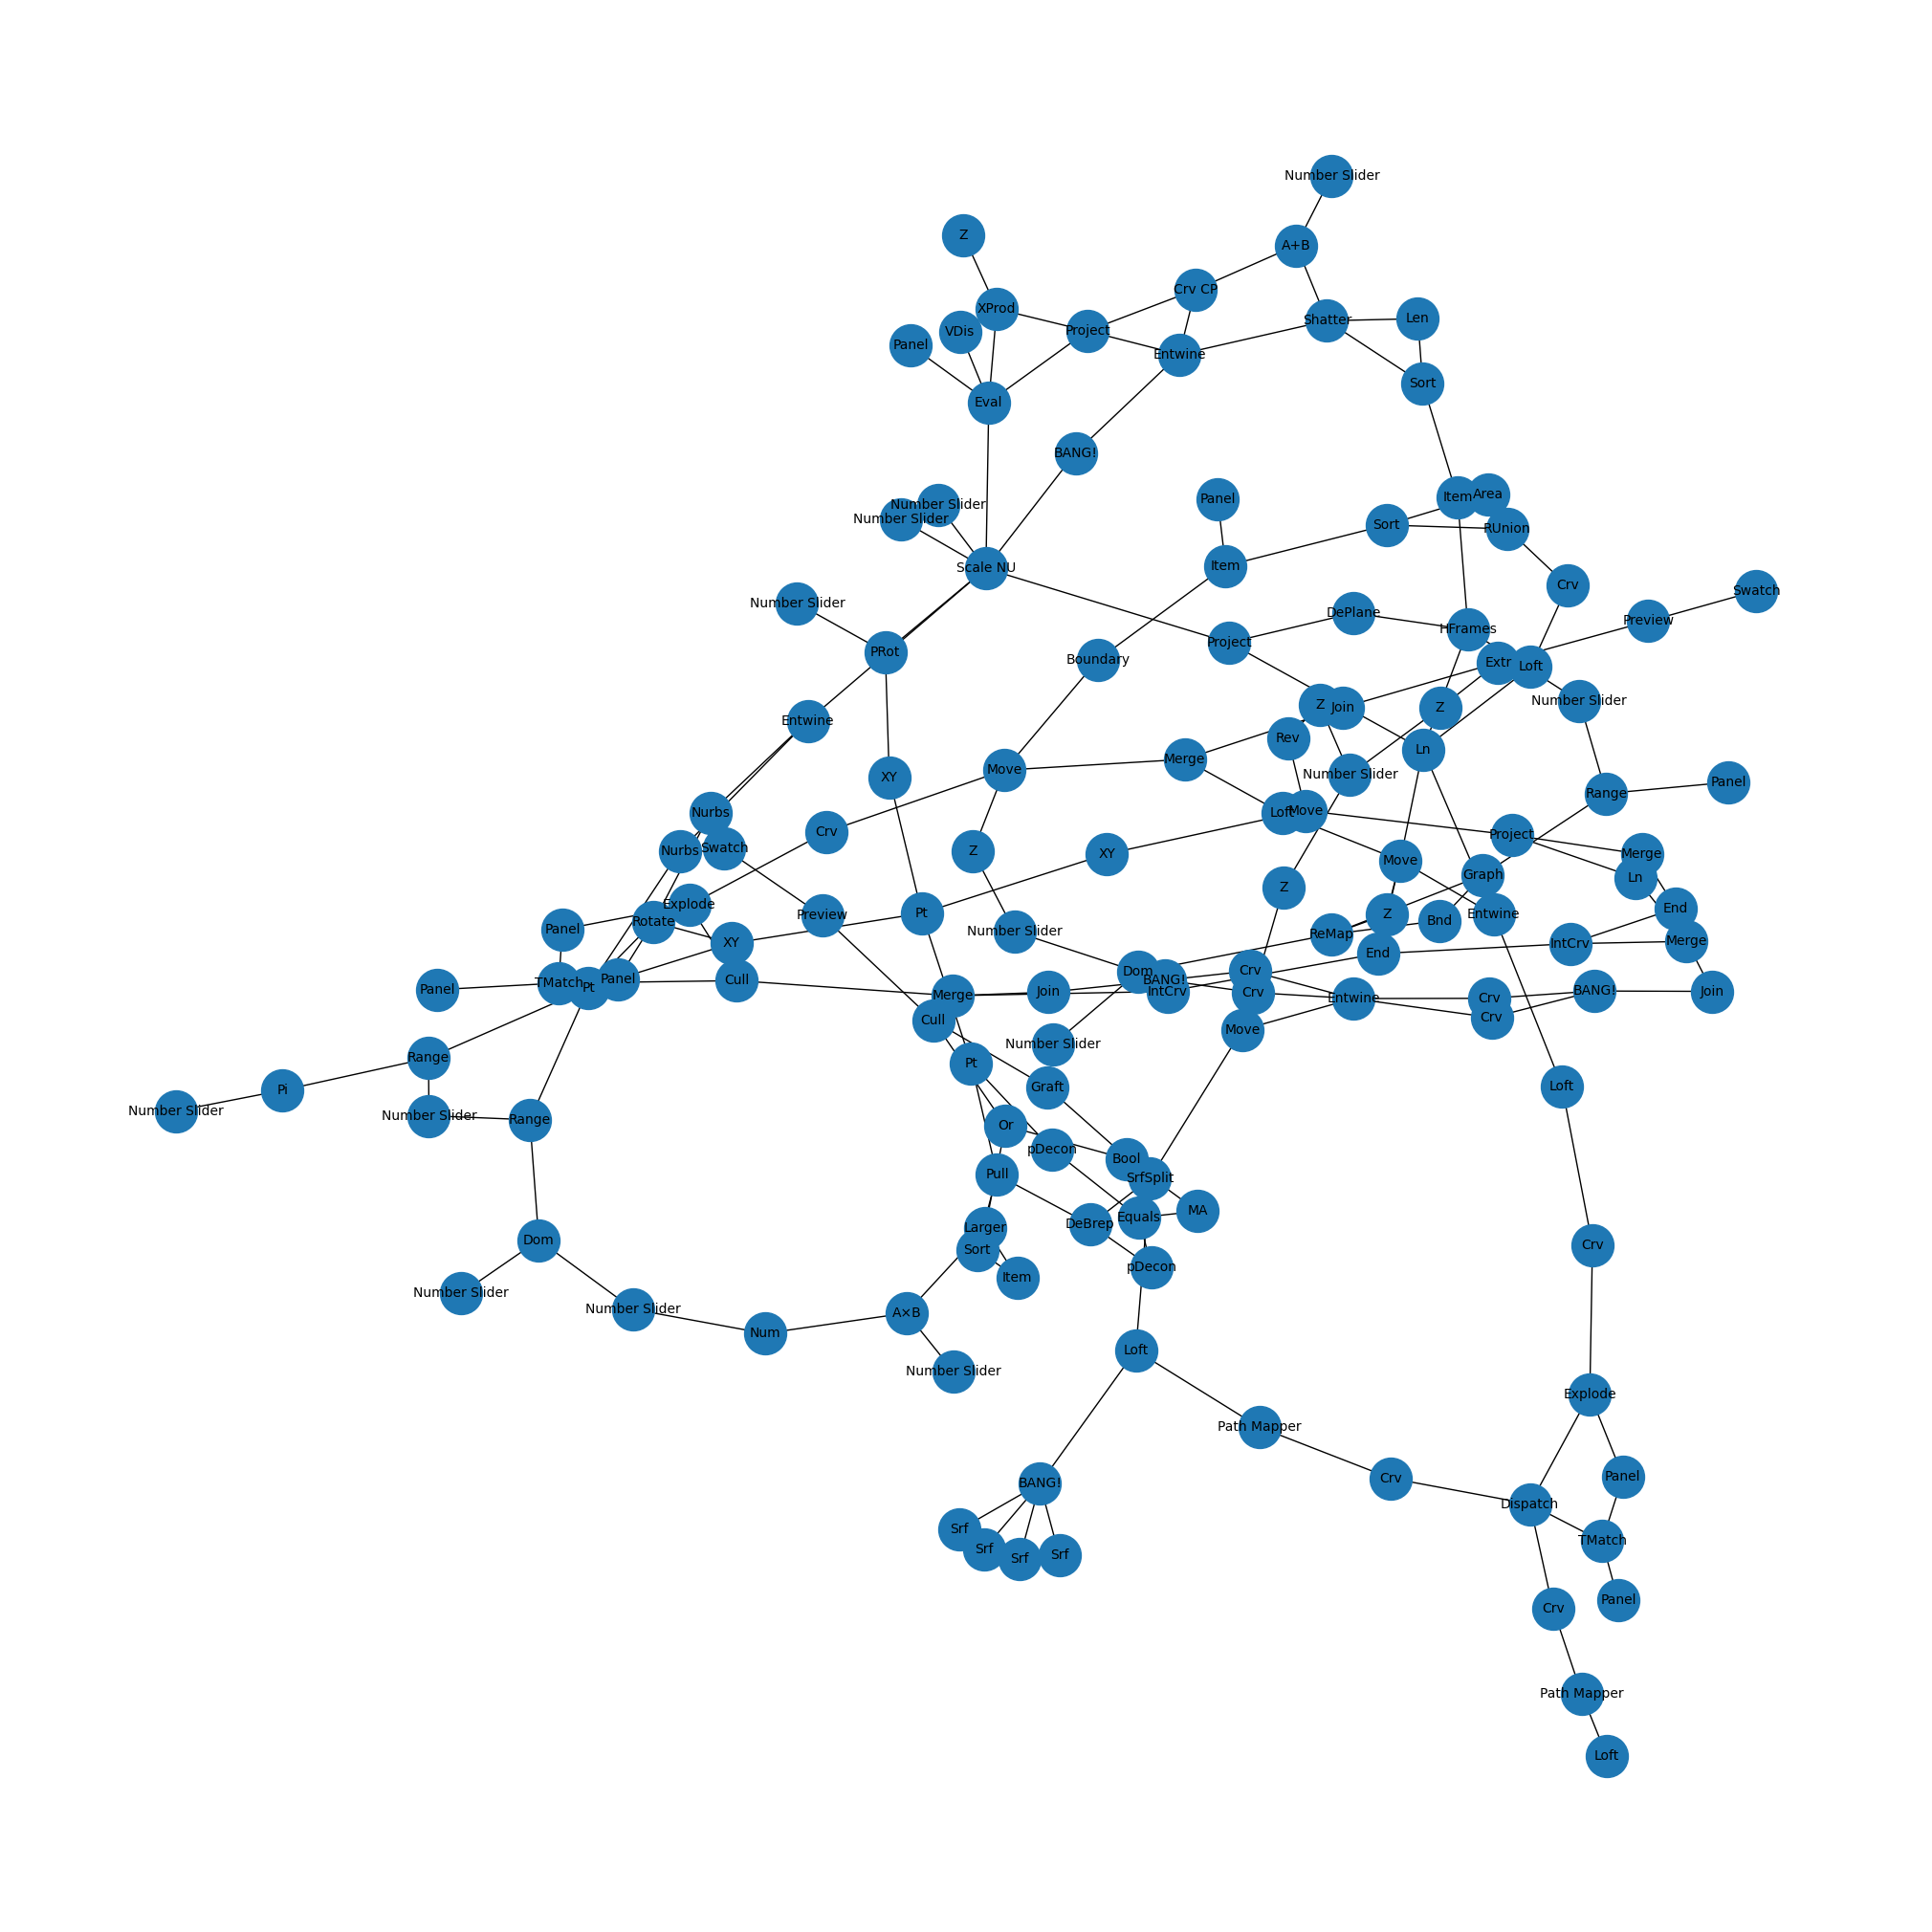

In [8]:
from IPython.display import display
import torch
from typing import Dict, List
import networkx as nx
import matplotlib.pyplot as plt
class Graph_Node:
    def __init__(self, component:GHComponent, n):
        self.component = component
        self.n = self.set_n(n)
        self.component.graph_id = str(self)
        self.id = str(self)
        self.sources, self.recipients = self.component.get_connections()
        self.connections: Dict[str: GraphConnection] = self.get_graph_connections()
        
    def set_n(self, n):
       return f"{n:03d}"
    
    def split_gh_graph_numbering(self, string):
        return [x for x in string.split("-")]
        
    def get_numbering(self, graph_id):
        """Safely gets the graph numbering, defaulting to -1 if the graph_id is None."""
        if graph_id is not None:
            return [int(x) for x in self.split_gh_graph_numbering(graph_id)]
        return -1, -1  # Default numbering if graph_id is None

    def get_graph_connections(self):
        graph_connections = {
            "sources": [],
            "recipients": []
        }
        
        # Process recipient connections (outgoing)
        for connection in self.recipients:
            v2 = connection.get("to")
            v1n, v1i = self.get_numbering(self.id)  # Always present, self.id should not be None
            v2n, v2i = self.get_numbering(v2.graph_id if v2 else None)
            edge = connection.get("edge")
            graph_connections["recipients"].append(GraphConnection(v1n, v1i, v2n, v2i, edge))
        
        # Process source connections (incoming)
        for connection in self.sources:
            v1 = connection.get("from")
            v1n, v1i = self.get_numbering(v1.graph_id if v1 else None)
            v2n, v2i = self.get_numbering(self.id)  # For incoming, self.id is the destination
            edge = [int(x) for x in connection.get("edge")]
            graph_connections["sources"].append(GraphConnection(v1n, v1i, v2n, v2i, edge))
    
        return graph_connections
    
    def __str__(self):
        return f"{self.component.global_idx}-{self.n}"
    
    def __repr__(self):
        return self.__str__()

class GraphConnection:
    
    def __init__(self, v1n, v1i, v2n, v2i, edge):
        self.v1n = v1n
        self.v1i = v1i
        self.v2n = v2n
        self.v2i = v2i
        self.e1 = edge[0]
        self.e2 = edge[1]
        self.tensor = torch.tensor([self.v1n, self.v1i, self.e1, self.v2n, self.v2i, self.e2], dtype=torch.int16)
    
    def __str__(self):
        return f"GC({self.v1n}-{self.v1i}, {self.v2n}-{self.v2i})"
    
    def __repr__(self):
        return str(self.tensor)
    

class GHGraph:
    def __init__(self):
        self.components = canvas.components
        self.component_mapping = self.create_component_mappings()
        self._graphnodes = [v for lst in self.component_mapping.values() for v in lst]
        self.ct = GHComponentTable()
        
    @property
    def nodes(self):
        return self._graphnodes
    
    @property
    def edges(self):
        edgs: List[GraphConnection] = []
        for node in self.nodes:
            for con in node.connections["recipients"]:
                edgs.append(con)
        return edgs
    
    @property
    def edge_tensor(self):
        return torch.stack([edge.tensor for edge in self.edges], dim=0)
    

    
    
    def nxGraph(self):
        plt.figure(figsize=(20, 20))
        
        gx = nx.Graph()  # Initialize the graph
        edges = []
        for con in self.edges:
            x  = (f"{con.v1n}-{con.v1i}", f"{con.v2n}-{con.v2i}")
            edges.append(x)
        # edges = [ for con in self.edges]  # Build edges
        gx.add_edges_from(edges)  # Add edges to the graph correctly
        return gx
    
    def show_graph(self):
        plt.figure(figsize=(12, 8))  # Adjust the figure size as desired
        gx = self.nxGraph()
    
        # Define custom labels for nodes to use only the part before the hyphen
        custom_labels = {node: self.ct.idx_to_component(int(node.split('-')[0])) for node in gx.nodes()}
        nans = [custom_labels.items()]
        nx.draw(gx, with_labels=True, labels=custom_labels, node_size=1000, font_size=10)
        plt.show()
    
    def save_graph(self, location):
        gx = self.nxGraph()
        nx.write_graphml(gx, location)
    
    def __str__(self):
        
        return f"{self.edges}"

graph = GHGraph()
graph.show_graph()
        

In [ ]:
table = GHComponentTable()
type(table.idx_to_component(634))

In [ ]:
GHComponentTable.initialize()

In [ ]:
GHComponentTable.idx_to_component(120)

In [5]:
from pathlib import Path


a = Path(r"C:\Users\jossi\Dropbox\Office_Work\Jos\GH_Graph_Learning\ExtractionEnvironments\240308-initial\03-GH_Files\test-BIG.gh")

In [7]:
a.

'test-BIG'